In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

import tensorflow as tf

seed = 42

tf.random.set_seed(seed)
np.random.seed(seed)
import seaborn as sns

tf_chkpt_path = 'tf_TransferLearning'

In [4]:
from src.helperFunctions import display_model_trainTestGraphs

In [5]:
# import tensorflow as tf
# tf.config.list_physical_devices()

# Training Set

In [6]:
# Normalizing data for 8 bit
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'images/train/',
    target_size = (227,227),
    batch_size=2,
    color_mode='rgb',
    class_mode='categorical'
)

Found 8960 images belonging to 7 classes.


# Validation Set

In [7]:
# Normalizing data for 8 bit
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'images/val/',
    target_size = (227,227),
    batch_size=10,
    color_mode='rgb',
    class_mode='categorical'
)

Found 2954 images belonging to 7 classes.


# Test Set

In [8]:
# Normalizing data for 8 bit
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'images/test/',
    target_size = (227,227),
    batch_size=1,
    color_mode='rgb',
    class_mode='categorical'
)

Found 311 images belonging to 7 classes.


# Modeling

In [9]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=1e-8,
                           verbose=1,
                           patience = 20,
                           restore_best_weights=True,
                           mode='min')

In [10]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch >100:
        return lr
    else:
        return lr * tf.math.exp(-0.01)
    
    
lr_schd_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [11]:
best_model = ModelCheckpoint(tf_chkpt_path+'best_model_3.hdf5', 
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min', 
                             save_freq='epoch')

# VGG 16

In [12]:
vgg = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    classes=7,
    classifier_activation='softmax',
    input_shape=(227,227,3),
)


In [18]:
model = tf.keras.Sequential([
  vgg,
  layers.Flatten(),
    layers.Dense(7, activation='softmax')
])


model.summary()

model.compile(optimizer=optimizers.Adam(learning_rate=0.0000005),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy',
                       Precision(),
                       Recall()
                       ])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 7)                 175623    
                                                                 
Total params: 14,890,311
Trainable params: 14,890,311
Non-trainable params: 0
_________________________________________________________________


In [19]:
results = model.fit(train_generator,
                    steps_per_epoch=50,
                    epochs=500,  # Number of epochs
                    validation_data=val_generator,
                    #                     validation_steps=50,
                    verbose=1,
                    callbacks=[
                        lr_schd_cb,
                        csv_logger,
                        #                         early_stop,
                        best_model
                    ]
                    )

Epoch 1/500
49/50 [============================>.] - ETA: 0s - loss: 2.1511 - accuracy: 0.0408 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 1: val_loss improved from inf to 1.93981, saving model to tf_TransferLearningbest_model_3.hdf5
50/50 [==============================] - 15s 287ms/step - loss: 2.1444 - accuracy: 0.0400 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.9398 - val_accuracy: 0.0464 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 5.0000e-07
Epoch 2/500
49/50 [============================>.] - ETA: 0s - loss: 2.0398 - accuracy: 0.0510 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 2: val_loss improved from 1.93981 to 1.84938, saving model to tf_TransferLearningbest_model_3.hdf5
50/50 [==============================] - 14s 280ms/step - loss: 2.0523 - accuracy: 0.0500 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.8494 - val_accuracy: 0.1317 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 5.0000e

Epoch 18/500
49/50 [============================>.] - ETA: 0s - loss: 1.3544 - accuracy: 0.5510 - precision_1: 0.8333 - recall_1: 0.2041
Epoch 18: val_loss improved from 1.41661 to 1.40121, saving model to tf_TransferLearningbest_model_3.hdf5
50/50 [==============================] - 14s 285ms/step - loss: 1.3785 - accuracy: 0.5400 - precision_1: 0.8333 - recall_1: 0.2000 - val_loss: 1.4012 - val_accuracy: 0.5264 - val_precision_1: 0.9003 - val_recall_1: 0.2018 - lr: 4.6156e-07
Epoch 19/500
49/50 [============================>.] - ETA: 0s - loss: 1.2568 - accuracy: 0.5510 - precision_1: 0.8966 - recall_1: 0.2653
Epoch 19: val_loss improved from 1.40121 to 1.38236, saving model to tf_TransferLearningbest_model_3.hdf5
50/50 [==============================] - 14s 283ms/step - loss: 1.2495 - accuracy: 0.5500 - precision_1: 0.9000 - recall_1: 0.2700 - val_loss: 1.3824 - val_accuracy: 0.5254 - val_precision_1: 0.9057 - val_recall_1: 0.2309 - lr: 4.5697e-07
Epoch 20/500
49/50 [================

49/50 [============================>.] - ETA: 0s - loss: 0.7090 - accuracy: 0.7755 - precision_1: 0.8986 - recall_1: 0.6327
Epoch 52: val_loss improved from 1.08023 to 1.06595, saving model to tf_TransferLearningbest_model_3.hdf5
50/50 [==============================] - 14s 285ms/step - loss: 0.7047 - accuracy: 0.7800 - precision_1: 0.9000 - recall_1: 0.6300 - val_loss: 1.0659 - val_accuracy: 0.7041 - val_precision_1: 0.8996 - val_recall_1: 0.5278 - lr: 3.2852e-07
Epoch 53/500
49/50 [============================>.] - ETA: 0s - loss: 0.7970 - accuracy: 0.7347 - precision_1: 0.9062 - recall_1: 0.5918
Epoch 53: val_loss improved from 1.06595 to 1.06457, saving model to tf_TransferLearningbest_model_3.hdf5
50/50 [==============================] - 14s 284ms/step - loss: 0.7851 - accuracy: 0.7400 - precision_1: 0.9091 - recall_1: 0.6000 - val_loss: 1.0646 - val_accuracy: 0.6984 - val_precision_1: 0.9010 - val_recall_1: 0.5267 - lr: 3.2525e-07
Epoch 54/500
49/50 [============================>

Epoch 89/500
49/50 [============================>.] - ETA: 0s - loss: 0.6416 - accuracy: 0.7755 - precision_1: 0.8961 - recall_1: 0.7041
Epoch 89: val_loss did not improve from 0.96703
50/50 [==============================] - 14s 280ms/step - loss: 0.6325 - accuracy: 0.7800 - precision_1: 0.8987 - recall_1: 0.7100 - val_loss: 0.9777 - val_accuracy: 0.7393 - val_precision_1: 0.8718 - val_recall_1: 0.6239 - lr: 2.2692e-07
Epoch 90/500
49/50 [============================>.] - ETA: 0s - loss: 0.5131 - accuracy: 0.8265 - precision_1: 0.8941 - recall_1: 0.7755
Epoch 90: val_loss did not improve from 0.96703
50/50 [==============================] - 14s 280ms/step - loss: 0.5259 - accuracy: 0.8200 - precision_1: 0.8953 - recall_1: 0.7700 - val_loss: 0.9977 - val_accuracy: 0.7346 - val_precision_1: 0.8701 - val_recall_1: 0.6148 - lr: 2.2466e-07
Epoch 91/500
49/50 [============================>.] - ETA: 0s - loss: 0.6016 - accuracy: 0.7653 - precision_1: 0.8750 - recall_1: 0.7143
Epoch 91: val_l

49/50 [============================>.] - ETA: 0s - loss: 0.6784 - accuracy: 0.7857 - precision_1: 0.8933 - recall_1: 0.6837
Epoch 108: val_loss did not improve from 0.95168
50/50 [==============================] - 14s 279ms/step - loss: 0.6655 - accuracy: 0.7900 - precision_1: 0.8961 - recall_1: 0.6900 - val_loss: 0.9619 - val_accuracy: 0.7512 - val_precision_1: 0.8637 - val_recall_1: 0.6456 - lr: 2.0126e-07
Epoch 109/500
49/50 [============================>.] - ETA: 0s - loss: 0.4847 - accuracy: 0.8469 - precision_1: 0.9167 - recall_1: 0.7857
Epoch 109: val_loss did not improve from 0.95168
50/50 [==============================] - 14s 281ms/step - loss: 0.4773 - accuracy: 0.8500 - precision_1: 0.9186 - recall_1: 0.7900 - val_loss: 0.9607 - val_accuracy: 0.7505 - val_precision_1: 0.8611 - val_recall_1: 0.6483 - lr: 2.0126e-07
Epoch 110/500
49/50 [============================>.] - ETA: 0s - loss: 0.4598 - accuracy: 0.8469 - precision_1: 0.9512 - recall_1: 0.7959
Epoch 110: val_loss did 

Epoch 127/500
49/50 [============================>.] - ETA: 0s - loss: 0.3988 - accuracy: 0.8878 - precision_1: 0.9205 - recall_1: 0.8265
Epoch 127: val_loss did not improve from 0.94047
50/50 [==============================] - 14s 281ms/step - loss: 0.4071 - accuracy: 0.8800 - precision_1: 0.9213 - recall_1: 0.8200 - val_loss: 0.9428 - val_accuracy: 0.7488 - val_precision_1: 0.8504 - val_recall_1: 0.6618 - lr: 2.0126e-07
Epoch 128/500
49/50 [============================>.] - ETA: 0s - loss: 0.3998 - accuracy: 0.8776 - precision_1: 0.9326 - recall_1: 0.8469
Epoch 128: val_loss improved from 0.94047 to 0.93791, saving model to tf_TransferLearningbest_model_3.hdf5
50/50 [==============================] - 14s 285ms/step - loss: 0.3923 - accuracy: 0.8800 - precision_1: 0.9341 - recall_1: 0.8500 - val_loss: 0.9379 - val_accuracy: 0.7471 - val_precision_1: 0.8544 - val_recall_1: 0.6594 - lr: 2.0126e-07
Epoch 129/500
49/50 [============================>.] - ETA: 0s - loss: 0.4929 - accuracy: 

Epoch 165/500
49/50 [============================>.] - ETA: 0s - loss: 0.4832 - accuracy: 0.8367 - precision_1: 0.9036 - recall_1: 0.7653
Epoch 165: val_loss did not improve from 0.92536
50/50 [==============================] - 14s 283ms/step - loss: 0.4886 - accuracy: 0.8300 - precision_1: 0.9048 - recall_1: 0.7600 - val_loss: 0.9385 - val_accuracy: 0.7583 - val_precision_1: 0.8444 - val_recall_1: 0.6835 - lr: 2.0126e-07
Epoch 166/500
49/50 [============================>.] - ETA: 0s - loss: 0.3282 - accuracy: 0.8878 - precision_1: 0.9302 - recall_1: 0.8163
Epoch 166: val_loss did not improve from 0.92536
50/50 [==============================] - 14s 281ms/step - loss: 0.3503 - accuracy: 0.8800 - precision_1: 0.9205 - recall_1: 0.8100 - val_loss: 0.9546 - val_accuracy: 0.7542 - val_precision_1: 0.8312 - val_recall_1: 0.6869 - lr: 2.0126e-07
Epoch 167/500
49/50 [============================>.] - ETA: 0s - loss: 0.5168 - accuracy: 0.8571 - precision_1: 0.9080 - recall_1: 0.8061
Epoch 167:

Epoch 203/500
49/50 [============================>.] - ETA: 0s - loss: 0.3380 - accuracy: 0.8878 - precision_1: 0.9130 - recall_1: 0.8571
Epoch 203: val_loss did not improve from 0.90877
50/50 [==============================] - 14s 281ms/step - loss: 0.3519 - accuracy: 0.8800 - precision_1: 0.9140 - recall_1: 0.8500 - val_loss: 0.9375 - val_accuracy: 0.7637 - val_precision_1: 0.8380 - val_recall_1: 0.6987 - lr: 2.0126e-07
Epoch 204/500
49/50 [============================>.] - ETA: 0s - loss: 0.4386 - accuracy: 0.8367 - precision_1: 0.9012 - recall_1: 0.7449
Epoch 204: val_loss did not improve from 0.90877
50/50 [==============================] - 14s 281ms/step - loss: 0.4311 - accuracy: 0.8400 - precision_1: 0.9036 - recall_1: 0.7500 - val_loss: 0.9205 - val_accuracy: 0.7681 - val_precision_1: 0.8451 - val_recall_1: 0.7038 - lr: 2.0126e-07
Epoch 205/500
49/50 [============================>.] - ETA: 0s - loss: 0.3006 - accuracy: 0.9184 - precision_1: 0.9667 - recall_1: 0.8878
Epoch 205:

49/50 [============================>.] - ETA: 0s - loss: 0.2901 - accuracy: 0.9082 - precision_1: 0.9451 - recall_1: 0.8776
Epoch 241: val_loss did not improve from 0.89822
50/50 [==============================] - 14s 280ms/step - loss: 0.2845 - accuracy: 0.9100 - precision_1: 0.9462 - recall_1: 0.8800 - val_loss: 0.9060 - val_accuracy: 0.7803 - val_precision_1: 0.8392 - val_recall_1: 0.7156 - lr: 2.0126e-07
Epoch 242/500
49/50 [============================>.] - ETA: 0s - loss: 0.4048 - accuracy: 0.8673 - precision_1: 0.9310 - recall_1: 0.8265
Epoch 242: val_loss did not improve from 0.89822
50/50 [==============================] - 14s 281ms/step - loss: 0.3967 - accuracy: 0.8700 - precision_1: 0.9326 - recall_1: 0.8300 - val_loss: 0.9125 - val_accuracy: 0.7739 - val_precision_1: 0.8357 - val_recall_1: 0.7079 - lr: 2.0126e-07
Epoch 243/500
49/50 [============================>.] - ETA: 0s - loss: 0.4549 - accuracy: 0.8776 - precision_1: 0.9213 - recall_1: 0.8367
Epoch 243: val_loss did 

Epoch 260/500
49/50 [============================>.] - ETA: 0s - loss: 0.4208 - accuracy: 0.8878 - precision_1: 0.9091 - recall_1: 0.8163
Epoch 260: val_loss did not improve from 0.88092
50/50 [==============================] - 14s 280ms/step - loss: 0.4286 - accuracy: 0.8800 - precision_1: 0.9101 - recall_1: 0.8100 - val_loss: 0.8854 - val_accuracy: 0.7827 - val_precision_1: 0.8443 - val_recall_1: 0.7326 - lr: 2.0126e-07
Epoch 261/500
49/50 [============================>.] - ETA: 0s - loss: 0.3790 - accuracy: 0.8571 - precision_1: 0.9390 - recall_1: 0.7857
Epoch 261: val_loss did not improve from 0.88092
50/50 [==============================] - 14s 280ms/step - loss: 0.3716 - accuracy: 0.8600 - precision_1: 0.9405 - recall_1: 0.7900 - val_loss: 0.9010 - val_accuracy: 0.7813 - val_precision_1: 0.8391 - val_recall_1: 0.7271 - lr: 2.0126e-07
Epoch 262/500
49/50 [============================>.] - ETA: 0s - loss: 0.3350 - accuracy: 0.8878 - precision_1: 0.9348 - recall_1: 0.8776
Epoch 262:

Epoch 298/500
49/50 [============================>.] - ETA: 0s - loss: 0.3862 - accuracy: 0.8469 - precision_1: 0.8737 - recall_1: 0.8469
Epoch 298: val_loss did not improve from 0.84697
50/50 [==============================] - 14s 280ms/step - loss: 0.3789 - accuracy: 0.8500 - precision_1: 0.8763 - recall_1: 0.8500 - val_loss: 0.8510 - val_accuracy: 0.7881 - val_precision_1: 0.8617 - val_recall_1: 0.7339 - lr: 2.0126e-07
Epoch 299/500
49/50 [============================>.] - ETA: 0s - loss: 0.4315 - accuracy: 0.8571 - precision_1: 0.9080 - recall_1: 0.8061
Epoch 299: val_loss did not improve from 0.84697
50/50 [==============================] - 14s 280ms/step - loss: 0.4254 - accuracy: 0.8600 - precision_1: 0.9101 - recall_1: 0.8100 - val_loss: 0.8674 - val_accuracy: 0.7769 - val_precision_1: 0.8477 - val_recall_1: 0.7292 - lr: 2.0126e-07
Epoch 300/500
49/50 [============================>.] - ETA: 0s - loss: 0.4214 - accuracy: 0.8367 - precision_1: 0.8710 - recall_1: 0.8265
Epoch 300:

49/50 [============================>.] - ETA: 0s - loss: 0.3110 - accuracy: 0.8980 - precision_1: 0.9231 - recall_1: 0.8571
Epoch 336: val_loss did not improve from 0.84592
50/50 [==============================] - 14s 280ms/step - loss: 0.3390 - accuracy: 0.8900 - precision_1: 0.9140 - recall_1: 0.8500 - val_loss: 0.8750 - val_accuracy: 0.7844 - val_precision_1: 0.8438 - val_recall_1: 0.7424 - lr: 2.0126e-07
Epoch 337/500
49/50 [============================>.] - ETA: 0s - loss: 0.3464 - accuracy: 0.8776 - precision_1: 0.9535 - recall_1: 0.8367
Epoch 337: val_loss did not improve from 0.84592
50/50 [==============================] - 14s 280ms/step - loss: 0.3406 - accuracy: 0.8800 - precision_1: 0.9545 - recall_1: 0.8400 - val_loss: 0.8693 - val_accuracy: 0.7884 - val_precision_1: 0.8514 - val_recall_1: 0.7448 - lr: 2.0126e-07
Epoch 338/500
49/50 [============================>.] - ETA: 0s - loss: 0.1882 - accuracy: 0.9490 - precision_1: 0.9681 - recall_1: 0.9286
Epoch 338: val_loss did 

Epoch 374/500
49/50 [============================>.] - ETA: 0s - loss: 0.1733 - accuracy: 0.9592 - precision_1: 0.9583 - recall_1: 0.9388
Epoch 374: val_loss improved from 0.83583 to 0.83028, saving model to tf_TransferLearningbest_model_3.hdf5
50/50 [==============================] - 14s 285ms/step - loss: 0.1767 - accuracy: 0.9600 - precision_1: 0.9592 - recall_1: 0.9400 - val_loss: 0.8303 - val_accuracy: 0.7935 - val_precision_1: 0.8435 - val_recall_1: 0.7590 - lr: 2.0126e-07
Epoch 375/500
49/50 [============================>.] - ETA: 0s - loss: 0.2582 - accuracy: 0.9286 - precision_1: 0.9556 - recall_1: 0.8776
Epoch 375: val_loss did not improve from 0.83028
50/50 [==============================] - 14s 280ms/step - loss: 0.2536 - accuracy: 0.9300 - precision_1: 0.9565 - recall_1: 0.8800 - val_loss: 0.8482 - val_accuracy: 0.7925 - val_precision_1: 0.8501 - val_recall_1: 0.7600 - lr: 2.0126e-07
Epoch 376/500
49/50 [============================>.] - ETA: 0s - loss: 0.2022 - accuracy: 

50/50 [==============================] - 14s 284ms/step - loss: 0.1472 - accuracy: 0.9600 - precision_1: 0.9697 - recall_1: 0.9600 - val_loss: 0.7922 - val_accuracy: 0.7952 - val_precision_1: 0.8536 - val_recall_1: 0.7620 - lr: 2.0126e-07
Epoch 393/500
49/50 [============================>.] - ETA: 0s - loss: 0.1960 - accuracy: 0.9184 - precision_1: 0.9560 - recall_1: 0.8878
Epoch 393: val_loss did not improve from 0.79223
50/50 [==============================] - 14s 280ms/step - loss: 0.1956 - accuracy: 0.9200 - precision_1: 0.9570 - recall_1: 0.8900 - val_loss: 0.8072 - val_accuracy: 0.7949 - val_precision_1: 0.8454 - val_recall_1: 0.7647 - lr: 2.0126e-07
Epoch 394/500
49/50 [============================>.] - ETA: 0s - loss: 0.2159 - accuracy: 0.9388 - precision_1: 0.9468 - recall_1: 0.9082
Epoch 394: val_loss did not improve from 0.79223
50/50 [==============================] - 14s 280ms/step - loss: 0.2197 - accuracy: 0.9400 - precision_1: 0.9474 - recall_1: 0.9000 - val_loss: 0.799

Epoch 412/500
49/50 [============================>.] - ETA: 0s - loss: 0.2153 - accuracy: 0.9082 - precision_1: 0.9468 - recall_1: 0.9082
Epoch 412: val_loss did not improve from 0.79223
50/50 [==============================] - 14s 279ms/step - loss: 0.2354 - accuracy: 0.9000 - precision_1: 0.9474 - recall_1: 0.9000 - val_loss: 0.8074 - val_accuracy: 0.7999 - val_precision_1: 0.8560 - val_recall_1: 0.7627 - lr: 2.0126e-07
Epoch 413/500
49/50 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.8980 - precision_1: 0.9556 - recall_1: 0.8776
Epoch 413: val_loss did not improve from 0.79223
50/50 [==============================] - 14s 279ms/step - loss: 0.2106 - accuracy: 0.9000 - precision_1: 0.9565 - recall_1: 0.8800 - val_loss: 0.7990 - val_accuracy: 0.8013 - val_precision_1: 0.8570 - val_recall_1: 0.7651 - lr: 2.0126e-07
Epoch 414/500
49/50 [============================>.] - ETA: 0s - loss: 0.1078 - accuracy: 0.9898 - precision_1: 1.0000 - recall_1: 0.9388
Epoch 414:

49/50 [============================>.] - ETA: 0s - loss: 0.1835 - accuracy: 0.9388 - precision_1: 0.9583 - recall_1: 0.9388
Epoch 450: val_loss did not improve from 0.78792
50/50 [==============================] - 14s 280ms/step - loss: 0.1873 - accuracy: 0.9400 - precision_1: 0.9588 - recall_1: 0.9300 - val_loss: 0.8432 - val_accuracy: 0.7993 - val_precision_1: 0.8433 - val_recall_1: 0.7688 - lr: 2.0126e-07
Epoch 451/500
49/50 [============================>.] - ETA: 0s - loss: 0.2505 - accuracy: 0.9286 - precision_1: 0.9381 - recall_1: 0.9286
Epoch 451: val_loss did not improve from 0.78792
50/50 [==============================] - 14s 280ms/step - loss: 0.2455 - accuracy: 0.9300 - precision_1: 0.9394 - recall_1: 0.9300 - val_loss: 0.8291 - val_accuracy: 0.8003 - val_precision_1: 0.8449 - val_recall_1: 0.7688 - lr: 2.0126e-07
Epoch 452/500
49/50 [============================>.] - ETA: 0s - loss: 0.2336 - accuracy: 0.9184 - precision_1: 0.9362 - recall_1: 0.8980
Epoch 452: val_loss did 

Epoch 488/500
49/50 [============================>.] - ETA: 0s - loss: 0.1930 - accuracy: 0.9082 - precision_1: 0.9368 - recall_1: 0.9082
Epoch 488: val_loss did not improve from 0.78126
50/50 [==============================] - 14s 280ms/step - loss: 0.1937 - accuracy: 0.9100 - precision_1: 0.9381 - recall_1: 0.9100 - val_loss: 0.7843 - val_accuracy: 0.7999 - val_precision_1: 0.8561 - val_recall_1: 0.7674 - lr: 2.0126e-07
Epoch 489/500
49/50 [============================>.] - ETA: 0s - loss: 0.1885 - accuracy: 0.9388 - precision_1: 0.9579 - recall_1: 0.9286
Epoch 489: val_loss improved from 0.78126 to 0.76834, saving model to tf_TransferLearningbest_model_3.hdf5
50/50 [==============================] - 14s 285ms/step - loss: 0.1849 - accuracy: 0.9400 - precision_1: 0.9588 - recall_1: 0.9300 - val_loss: 0.7683 - val_accuracy: 0.8003 - val_precision_1: 0.8560 - val_recall_1: 0.7664 - lr: 2.0126e-07
Epoch 490/500
49/50 [============================>.] - ETA: 0s - loss: 0.1156 - accuracy: 

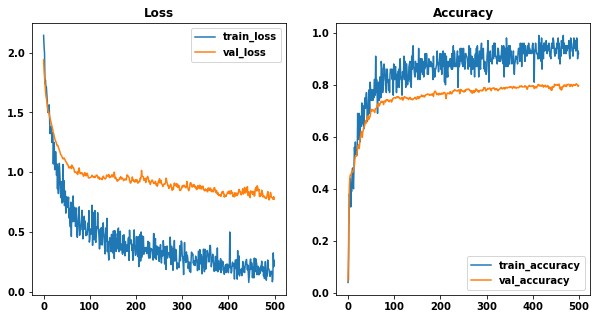

In [20]:
display_model_trainTestGraphs(results)

In [21]:
m = models.load_model('tf_TransferLearningbest_model_3.hdf5')

In [22]:
m.evaluate(val_generator)

296/296 [==============================] - 13s 40ms/step - loss: 0.7683 - accuracy: 0.8003 - precision_1: 0.8560 - recall_1: 0.7664


[0.768343448638916, 0.8002707958221436, 0.855954647064209, 0.7664183974266052]

In [23]:
m.evaluate(test_generator)

311/311 [==============================] - 3s 9ms/step - loss: 1.1897 - accuracy: 0.7331 - precision_1: 0.7758 - recall_1: 0.7010


[1.1896965503692627, 0.7331189513206482, 0.7758007049560547, 0.700964629650116]

In [ ]:
test_generator.class_indices